In [14]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import uuid

def run_simulation(T=200, arrival_rate=0.8, service_delay_A=2, service_delay_B=2,
                   service_delay_C=2, rework_prob=0.2, seed=42):
    np.random.seed(seed)

    # First pass to determine max number of entities
    estimated_arrivals = int(arrival_rate * T * 1.5)  # generous upper bound
    queues = ['A', 'B', 'C', 'System']
    presence = {
        q: np.zeros((estimated_arrivals, T), dtype=bool)
        for q in queues
    }
    entity_index = {}
    queue_A, queue_B, queue_C = deque(), deque(), deque()
    entity_counter = 0

    def process_queue(queue, service_delay, current_time, next_queue):
        new_queue = deque()
        for item in queue:
            if current_time - item['start_time'] >= service_delay:
                if next_queue is not None:
                    item['start_time'] = current_time
                    next_queue.append(item)
            else:
                new_queue.append(item)
        return new_queue

    for t in range(T):
        if np.random.rand() < arrival_rate:
            entity_id = str(uuid.uuid4())
            entity_index[entity_id] = entity_counter
            queue_A.append({'id': entity_id, 'start_time': t})
            entity_counter += 1

        new_C = deque()
        for item in queue_C:
            if t - item['start_time'] >= service_delay_C:
                if np.random.rand() < rework_prob:
                    item['start_time'] = t
                    queue_A.append(item)
                # Else exits the system
            else:
                new_C.append(item)
        queue_C = new_C

        queue_B = process_queue(queue_B, service_delay_B, t, queue_C)
        queue_A = process_queue(queue_A, service_delay_A, t, queue_B)

        for queue_id, queue in zip(['A', 'B', 'C'], [queue_A, queue_B, queue_C]):
            for item in queue:
                row = entity_index[item['id']]
                presence[queue_id][row, t] = True
                presence['System'][row, t] = True

    return presence, entity_index

def get_entry_exit_times(presence, entity_index, queue_name):
    arrivals = []
    departures = []
    mat = presence[queue_name]
    for i in range(mat.shape[0]):
        times = np.where(mat[i])[0]
        if times.size > 0:
            arrivals.append(times[0])
            departures.append(times[-1] + 1)
    return arrivals, departures

def plot_cumulative_flow(queue_name, presence, entity_index, T=200):
    entry_times, exit_times = get_entry_exit_times(presence, entity_index, queue_name)
    arrivals = np.zeros(T)
    departures = np.zeros(T)
    for t in entry_times:
        if t < T:
            arrivals[t] += 1
    for t in exit_times:
        if t < T:
            departures[t] += 1
    cumulative_arrivals = np.cumsum(arrivals)
    cumulative_departures = np.cumsum(departures)
    plt.figure(figsize=(10, 5))
    plt.plot(range(T), cumulative_arrivals, label='Cumulative Arrivals')
    plt.plot(range(T), cumulative_departures, label='Cumulative Departures')
    plt.title(f"Cumulative Flow Diagram (Queue {queue_name})")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



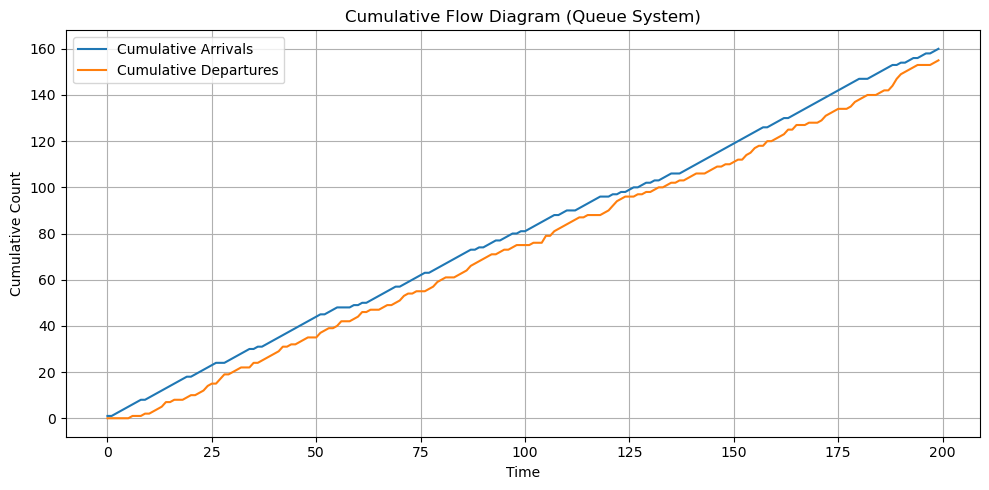

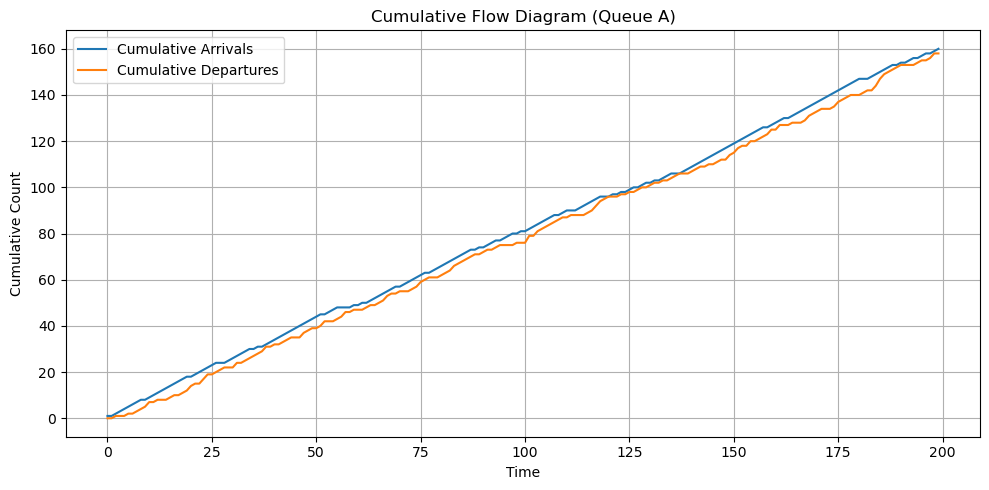

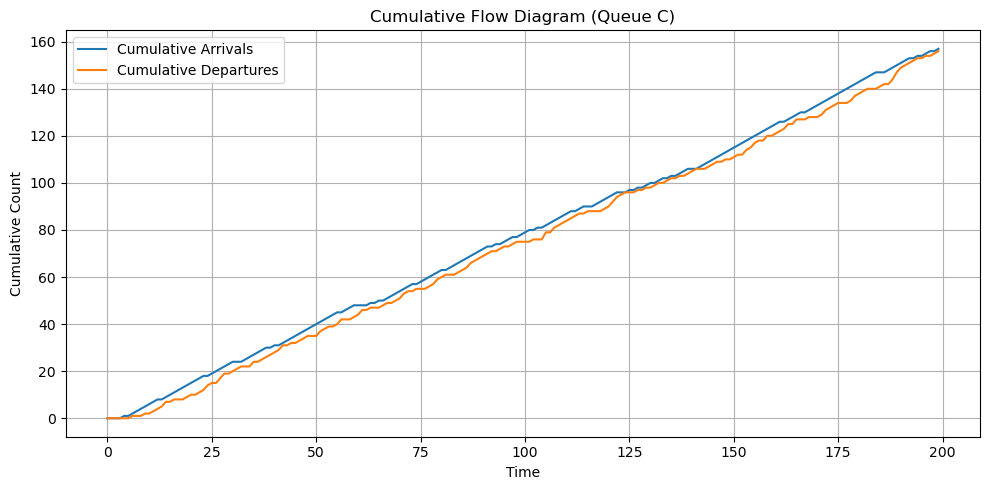

In [15]:
presence, entity_index = run_simulation()

plot_cumulative_flow("System", presence, entity_index)

plot_cumulative_flow("A", presence, entity_index)

plot_cumulative_flow("C", presence, entity_index)
